# Ford GoBike Bike Sharing Analysis

Ford GoBike is the Bay Area's bike share system. Bay Area Bike Share was introduced in 2013 as a pilot program for the region, with 700 bikes and 70 stations across San Francisco and San Jose. Once expansion is complete, Ford GoBike will grow to 7,000 bikes across San Francisco, the East Bay and San Jose. 

In this research, we intended to answer the following big questions: 
1. Which timing of the following rides is busiest during the days, months and hours? 
2. How does the duration trip trend look like? 
3. Is there any particular effect of the operational area? 
4. Whether subscriber have different trend than normal customer from 2017-2018?


## Preliminary Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import requests
from requests import get
from zipfile import ZipFile
import os
from os import path, getcwd, listdir 
from io import BytesIO
import json
import calendar
import seaborn as sb
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
%matplotlib inline

In [5]:
df = pd.read_csv('master_data.csv')

C:\Users\ASUS\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Repair the datatype and creating age column

In [8]:
df['duration_sec'] = df['duration_sec'].apply(float)
df['bike_id'] = df['bike_id'].apply(str)
df['end_station_id'] = df['end_station_id'].apply(float)
df['start_station_id'] = df['start_station_id'].apply(float)
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_time'] = pd.to_datetime(df['start_time'])

In [11]:
df['age'] = 2018-df['member_birth_year']

In [13]:
df['age'].describe()

count    2.206162e+06
mean     3.546318e+01
std      1.051346e+01
min      1.800000e+01
25%      2.800000e+01
50%      3.300000e+01
75%      4.100000e+01
max      1.370000e+02
Name: age, dtype: float64

We found out that there are some of the age data that are completely impossible such as the maximum value is 137 years old, there is a need to recheck this age column dataset

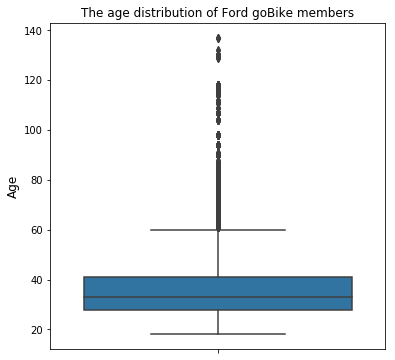

In [14]:
plt.figure(figsize=(6,6))
base_color = sb.color_palette()[0]
sb.boxplot(data = df, y = 'age', color = base_color)
plt.title('The age distribution of Ford goBike members', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.savefig('The age distribution of Ford goBike members.png')

By the boxplot, we can determine that the outlier lies beyond 60 years old, so we will be discarding those with outlier values (above 60 and null value) 

In [15]:
df1 = df.query('(age <= 60) & (age == age)')

In [18]:
df1['age'] = df1['age'].apply(int)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Creating area column 
Now we will add another variable called area in order for us to know the trends of the operational areas of Ford GoBike: San Fransico, East Bay and San Jose

In [19]:
df1.start_station_longitude.describe()

count    2.156049e+06
mean    -1.223515e+02
std      1.583654e-01
min     -1.224737e+02
25%     -1.224116e+02
50%     -1.223974e+02
75%     -1.222914e+02
max     -7.357000e+01
Name: start_station_longitude, dtype: float64

After doing some checking with the age column, we just sample through some of the start station longitude and found out that there are impossible data values with the start station longitude for the max as well

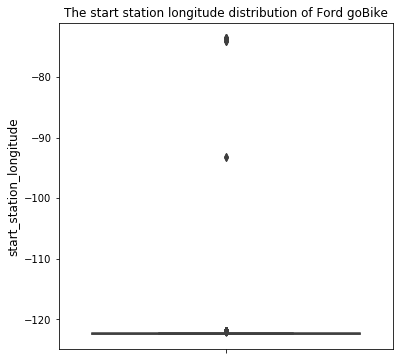

In [20]:
plt.figure(figsize=(6,6))
base_color = sb.color_palette()[0]
sb.boxplot(data = df, y = 'start_station_longitude', color = base_color)
plt.title('The start station longitude distribution of Ford goBike', fontsize=12)
plt.ylabel('start_station_longitude', fontsize=12)
plt.savefig('The start station longitude distribution of Ford goBike.png')

In [22]:
df2 = df1.copy()
df2['area'] = df2.apply(area_df, axis = 1)

In [24]:
dfnan = df2.query('area != area')
dfnan

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,area
6,6,6.0,3539,NaN,4507.0,259.0,37.866249,-122.299371,Addison St at Fourth St,2018-01-01 01:04:35.619,1991.0,Female,259.0,37.866249,-122.299371,Addison St at Fourth St,2017-12-31 23:49:28.422,Customer,27,NaN
33,33,33.0,3539,NaN,781.0,259.0,37.866249,-122.299371,Addison St at Fourth St,2017-12-31 23:46:54.972,1991.0,Female,251.0,37.870555,-122.279720,California St at University Ave,2017-12-31 23:33:52.981,Customer,27,NaN
52,52,52.0,2966,NaN,707.0,259.0,37.866249,-122.299371,Addison St at Fourth St,2017-12-31 23:25:55.455,1994.0,Male,245.0,37.870348,-122.267764,Downtown Berkeley BART,2017-12-31 23:14:07.542,Customer,24,NaN
189,189,189.0,2985,NaN,1711.0,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:54.700,1992.0,Male,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:48:23.684,Subscriber,26,NaN
190,190,190.0,2736,NaN,1208.0,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:51.551,1994.0,Male,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:56:43.394,Subscriber,24,NaN
191,191,191.0,3398,NaN,1699.0,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:47.224,1993.0,Male,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:48:28.104,Subscriber,25,NaN
192,192,192.0,3496,NaN,1697.0,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:40.608,1993.0,Female,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:48:23.404,Subscriber,25,NaN
294,294,294.0,2456,NaN,528.0,16.0,37.794130,-122.394430,Steuart St at Market St,2017-12-31 18:13:40.127,1994.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 18:04:51.785,Customer,24,NaN
310,310,310.0,2456,NaN,1596.0,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 18:01:49.197,1994.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 17:35:13.180,Customer,24,NaN
332,332,332.0,1518,NaN,285.0,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2017-12-31 17:47:17.839,1982.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 17:42:32.477,Subscriber,36,NaN


We found out that there are more than 131k entries that did not get included into the coordinates above, we would update the latitiude and longitude accordingly 

In [31]:
dfnan.query('end_station_longitude == -122.473658')

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,area
1657265,119179,NaN,3798,No,387.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 18:46:52.081,1994.0,Female,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 18:40:24.340,Customer,24,NaN
1657309,119223,NaN,3664,No,10042.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 18:38:33.455,1994.0,Male,323.0,37.798014,-122.405950,Broadway at Kearny,2018-08-12 15:51:10.487,Subscriber,24,NaN
1657312,119226,NaN,4029,No,10080.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 18:38:24.669,1992.0,Male,323.0,37.798014,-122.405950,Broadway at Kearny,2018-08-12 15:50:24.226,Customer,26,NaN
1657596,119510,NaN,1379,No,2256.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 17:40:30.630,1992.0,Female,29.0,37.782405,-122.439446,O'Farrell St at Divisadero St,2018-08-12 17:02:53.656,Customer,26,NaN
1657597,119511,NaN,2784,No,1898.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 17:40:21.943,1991.0,Male,29.0,37.782405,-122.439446,O'Farrell St at Divisadero St,2018-08-12 17:08:43.264,Customer,27,NaN
1657738,119652,NaN,3388,No,1178.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 17:14:23.418,1964.0,Male,71.0,37.773063,-122.439078,Broderick St at Oak St,2018-08-12 16:54:44.844,Subscriber,54,NaN
1657997,119911,NaN,3034,No,897.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 16:31:43.401,1984.0,Male,70.0,37.773311,-122.444293,Central Ave at Fell St,2018-08-12 16:16:46.365,Subscriber,34,NaN
1657998,119912,NaN,3186,No,912.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 16:31:21.529,1985.0,Female,70.0,37.773311,-122.444293,Central Ave at Fell St,2018-08-12 16:16:08.610,Subscriber,33,NaN
1658009,119923,NaN,506,No,1652.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 16:30:04.490,1989.0,Female,52.0,37.777416,-122.441838,McAllister St at Baker St,2018-08-12 16:02:32.112,Customer,29,NaN
1658220,120134,NaN,3798,Yes,1709.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 15:53:37.133,1962.0,Other,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 15:25:08.021,Subscriber,56,NaN


We also find out that there are temporary stations

#### Revision 
After the trial and errors, we manage to find all of the necessary latitude and longitude (both max and min) and revise the adjusted minimum and maximum of both latitude and longitude  
####  San Fransisco: (37.722702 - 37.799692) (-122.446286 - -122.387408)
- 37.771104, -122.473658 Outside Lands 2018 (Temporary Station)
- 37.80477, -122.403234 (The embarcadero)
- 37.771917, -122.453704 (Fell St)
- 37.739853, -122.385655	(Mendell St at Fairfax Ave)
####  East Bay: (37.782897 - 37.880090) (-122.298648 - -122.220277) 
- 37.866249, -122.299371 (Addison St at Fourth St)
- 37.880222, -122.269592 (Vine St at Shattuck Ave)
- 37.775232, -122.224498 (Fruitvale BART Station)
- 37.870407, -122.299676 (Fifth St at Delaware St)
- 37.779930, -122.217728 (Foothill Blvd at Harrington Ave)
- 37.775745, -122.213037	(Foothill Blvd at 42nd Ave)
####  San Jose: (37.280258 - 37.368621) (-121.917525 - -121.834908)
- 37.263310, -121.833332 (viva calle sj) 
- 37.810743	-122.291415	14th St at Mandela Pkwy

#### Conclusion 
1. San Fransisco: (37.722702 - 37.80477) (-122.453705 - -122.385654)
2. East Bay     : (37.775232 - 37.880223) (-122.299676 - -122.213036) 
3. San Jose     : (37.263310 - 37.368621) (-121.917525 - -121.833332)

In [33]:
def area_df2(df1):
    
    if (((37.722702 <= df1.end_station_latitude <= 37.80477) & (37.722702 <= df1.start_station_latitude <= 37.80477)) & ((-122.453705 <= df1.end_station_longitude <= -122.385654) & (-122.453705 <= df1.start_station_longitude <= -122.385654))):
        return 'SF'
    elif (((37.775232 <= df1.end_station_latitude <= 37.880223) & (37.775232 <= df1.start_station_latitude <= 37.880223)) & ((-122.299676 <= df1.end_station_longitude <= -122.213036) & (-122.299676 <= df1.start_station_longitude <= -122.213036))):
        return 'EB'
    elif (((37.263310 <= df1.end_station_latitude <= 37.368621) & (37.263310 <= df1.start_station_latitude <= 37.368621)) & ((-121.917525 <= df1.end_station_longitude <= -121.833332) & (-121.917525 <= df1.start_station_longitude <= -121.833332))):
        return 'SJ'
    elif ((df1.end_station_name == 'Outside Lands 2018 (Temporary Station)') | (df1.start_station_name == 'Outside Lands 2018 (Temporary Station)')):
        return 'Temp'
    else:
        return np.nan

In [34]:
df2['area'] = df2.apply(area_df2, axis = 1)

In [36]:
df3 = df2.dropna(subset=['end_station_name', 'start_station_name'])

In [37]:
dfnan = df3.query('area != area')
dfnan

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,area
124544,124544,124544.0,1230,NaN,2037.0,4.0,37.785881,-122.408915,Cyril Magnin St at Ellis St,2017-11-17 15:56:51.165,1969.0,Male,209.0,37.833558,-122.267418,45th St at MLK Jr Way,2017-11-17 15:22:53.773,Subscriber,49,NaN
185190,185190,185190.0,1210,NaN,5471.0,312.0,37.329732,-121.901782,San Jose Diridon Station,2017-10-31 09:28:29.835,1976.0,Male,195.0,37.812314,-122.260779,Bay Pl at Vernon St,2017-10-31 07:57:18.251,Subscriber,42,NaN
192832,192832,192832.0,450,NaN,2278.0,209.0,37.833558,-122.267418,45th St at MLK Jr Way,2017-10-28 15:45:36.831,1969.0,Male,41.0,37.781270,-122.418740,Golden Gate Ave at Polk St,2017-10-28 15:07:37.864,Subscriber,49,NaN
193555,193555,193555.0,1050,NaN,13305.0,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2017-10-28 12:30:39.791,1978.0,Male,183.0,37.808702,-122.269927,Telegraph Ave at 19th St,2017-10-28 08:48:53.981,Customer,40,NaN
194062,194062,194062.0,1356,NaN,3331.0,16.0,37.794130,-122.394430,Steuart St at Market St,2017-10-28 09:36:12.432,1982.0,Female,183.0,37.808702,-122.269927,Telegraph Ave at 19th St,2017-10-28 08:40:40.892,Subscriber,36,NaN
194092,194092,194092.0,652,NaN,2308.0,41.0,37.781270,-122.418740,Golden Gate Ave at Polk St,2017-10-28 09:04:40.314,1969.0,Male,209.0,37.833558,-122.267418,45th St at MLK Jr Way,2017-10-28 08:26:11.382,Subscriber,49,NaN
195522,195522,195522.0,2123,NaN,4241.0,178.0,37.819381,-122.261928,Broadway at 30th St,2017-10-27 17:31:12.351,1983.0,Male,81.0,37.775880,-122.393170,Berry St at 4th St,2017-10-27 16:20:31.340,Subscriber,35,NaN
255087,255087,255087.0,2961,NaN,2579.0,22.0,37.789756,-122.394643,Howard St at Beale St,2017-10-11 08:39:36.012,1985.0,Male,185.0,37.801858,-122.265368,Jackson St at 14th St,2017-10-11 07:56:36.340,Subscriber,33,NaN
263649,263649,263649.0,3027,NaN,16338.0,197.0,37.808848,-122.249680,El Embarcadero at Grand Ave,2017-10-08 18:08:45.021,1983.0,Female,71.0,37.773063,-122.439078,Broderick St at Oak St,2017-10-08 13:36:26.861,Customer,35,NaN
275559,275559,275559.0,1581,NaN,4496.0,284.0,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,2017-10-05 08:29:11.084,1983.0,Female,221.0,37.794353,-122.253875,12th St at 6th Ave,2017-10-05 07:14:14.303,Subscriber,35,NaN


In [38]:
dfnan['start_station_latitude'].value_counts().sort_values

<bound method Series.sort_values of 37.829705    7
37.801858    7
37.810743    5
37.807239    4
37.795392    3
37.869360    3
37.797673    3
37.812314    3
37.808750    3
37.812331    3
37.800002    2
37.808702    2
37.833558    2
37.783899    2
37.804562    2
37.795393    2
37.795195    2
37.830545    2
37.823847    2
37.809824    2
37.781270    2
37.783757    2
37.808848    2
37.774814    2
37.869060    2
37.794130    1
37.773063    1
37.778742    1
37.800516    1
37.776754    1
37.798014    1
37.866043    1
37.791464    1
37.869060    1
37.792251    1
37.776619    1
37.831275    1
37.783521    1
37.759200    1
37.868813    1
37.775880    1
37.797320    1
37.827757    1
37.789756    1
37.827757    1
37.855956    1
37.781074    1
37.794353    1
37.787492    1
Name: start_station_latitude, dtype: int64>

There are some of the latitude and longitude that have nan value; however, due to their low numbers of 95 entries, we can just drop them 

In [39]:
df3 = df3.dropna(subset=['area'])

#### Creating column for the hourly, monthly and weekdays 

In [42]:
df3['start_time_date']=df3['start_time'].dt.date
df3['end_time_date']=df3['end_time'].dt.date

In [43]:
df3['start_time_year_month']=df3['start_time'].map(lambda x: x.strftime('%Y-%m'))
df3['end_time_year_month']=df3['end_time'].map(lambda x: x.strftime('%Y-%m'))

In [44]:
df3['start_time_hour_minute']=df3['start_time'].map(lambda x: x.strftime('%H-%m'))
df3['end_time_hour_minute']=df3['end_time'].map(lambda x: x.strftime('%H-%m'))

In [45]:
df3['start_time_hour']=df3['start_time'].dt.hour
df3['end_time_hour']=df3['end_time'].dt.hour

In [46]:
df3['start_time_weekday']=df3['start_time'].dt.weekday_name
df3['end_time_weekday']=df3['end_time'].dt.weekday_name

In [47]:
df3['start_time_weekday_abbr']=df3['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df3['end_time_weekday_abbr']=df3['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

In [50]:
df4 = df3.drop(['Unnamed: 0', 'Unnamed: 0.1', 'end_station_latitude', 'end_station_longitude', 'member_birth_year', 'start_station_latitude', 'start_station_longitude'], axis=1)

#### Filtering based on the Trip Duration

In [51]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2144559 entries, 0 to 2383419
Data columns (total 25 columns):
bike_id                    object
bike_share_for_all_trip    object
duration_sec               float64
end_station_id             float64
end_station_name           object
end_time                   datetime64[ns]
member_gender              object
start_station_id           float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
age                        int64
area                       object
start_time_date            object
end_time_date              object
start_time_year_month      object
end_time_year_month        object
start_time_hour_minute     object
end_time_hour_minute       object
start_time_hour            int64
end_time_hour              int64
start_time_weekday         object
end_time_weekday           object
start_time_weekday_abbr    object
end_time_weekday_abbr      object
dtypes: datetime64[ns

In [52]:
df4['duration_min'] = df4['duration_sec']/60 

Text(0,0.5,'duration_min')

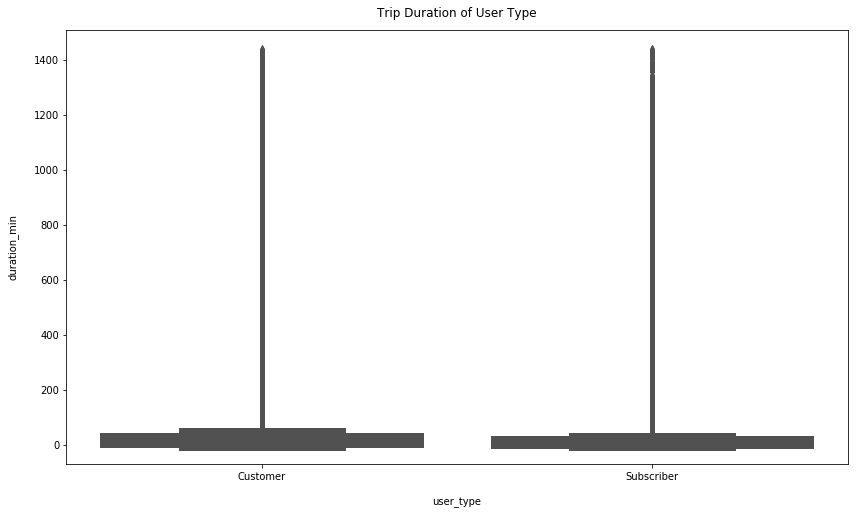

In [53]:
plt.figure(figsize=(14,8))
my_palette = {'Subscriber':'#3498db', 'Customer':'#e74c3c'}
ax = sb.boxplot(x='user_type', y='duration_min', linewidth=11, palette=my_palette, data= df4)
plt.title('Trip Duration of User Type', y=1.015)
plt.xlabel('user_type', labelpad=16)
plt.ylabel('duration_min', labelpad=16)

We found out that the company policy only allowed maximum borrowing time 45 minutes with additional 15 minutes for extra charge of $3 for each additional 15 minutes. So we will create a threshold of 60 minutes for trip duration

In [55]:
df5 = df4.query('duration_min <= 60')

## Explanatory Analysis
After filtering the data based on the area, trip duration and the age, we will answer the following questions based on our new dataset of the Ford Go Bike Ride 
### Question 1: Which timing of the following rides is busiest during the days, months and hours? 

We will delve into which time of the days, months and hours is the most crowded and the reason for the trends

### Monthly Usage of Bike Share System
For monthly trend, we can see a pattern: There are increasing trends for each month with slight down trend for the November and December. The reason might be the weather as well as holidays 

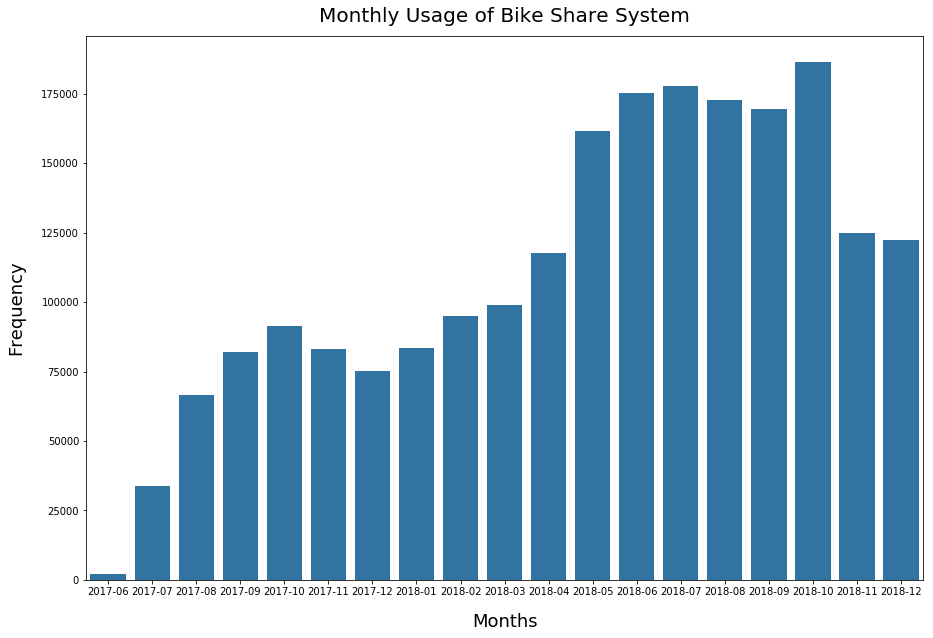

In [176]:
plt.figure(figsize=(15,10))
sb.barplot(data=ym_df, x='start_time_year_month', y='count', color = base_color)
plt.title("Monthly Usage of Bike Share System", fontsize=20, y=1.015)
plt.xlabel('Months', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)
plt.savefig('Monthly Usage of Bike Share System.png')

### Daily Usage of Bike Share System
For the weekdays, The busiest time is Tuesday followed by Wednesday while the day with the least traffic is weekends (Saturday and Sunday) 

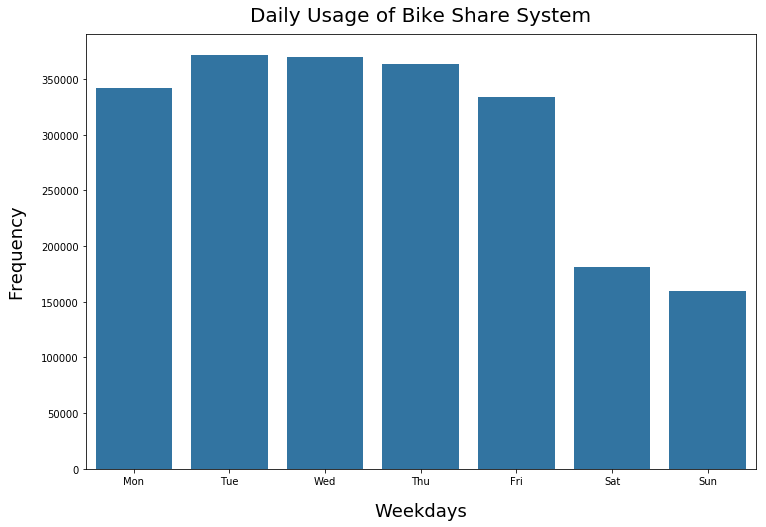

In [177]:
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(12,8))
sb.barplot(data=days_df, x='start_time_weekday_abbr', y='count', color = base_color, order= weekday)
plt.title("Daily Usage of Bike Share System", fontsize=20, y=1.015)
plt.xlabel('Weekdays', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)
plt.savefig('Daily Usage of Bike Share System.png')

### Hourly Usage of Bike Share System
for the hours, the busiest hours are 8am and 5pm, the time where people going to work or starting their activities 

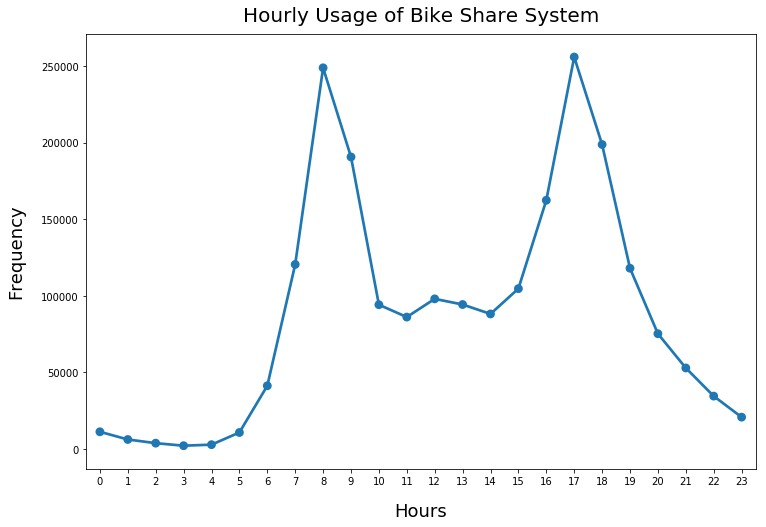

In [178]:
plt.figure(figsize=(12,8))
sb.pointplot(data=hour_df, x='start_time_hour', y='count', color = base_color)
plt.title("Hourly Usage of Bike Share System", fontsize=20, y=1.015)
plt.xlabel('Hours', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)
plt.savefig('Hourly Usage of Bike Share System.png')

### Question 2: How does the duration trip trend look like? 

By knowing the duration trend of the trips, we can get insight and set benchmark for the next questions

### Distribution of Trip Duration
The average duration of the trip is 10.8 minutes with the limitation of 60 minutes of each trip set by the Ford Go Bike 

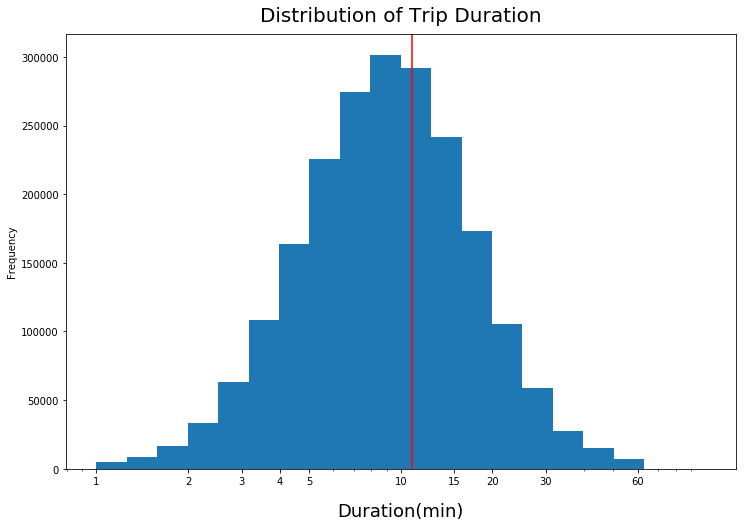

In [179]:
plt.figure(figsize=(12,8))
bins = 10**np.arange(0 , 2+0.1 , 0.1)
ticks =  [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]
labels = ['{}'.format(val) for val in ticks]
plt.hist(data = df5 , x = 'duration_min' , bins = bins);
plt.xlabel('Duration(min)', fontsize=18, labelpad=16)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.title('Distribution of Trip Duration', fontsize=20, y=1.015)
plt.ylabel('Frequency')
plt.axvline(x=df5['duration_min'].mean(), color='red')
plt.savefig('Distribution of Trip Duration.png')

### Question 3: Is there any particular effect of the operational area? 

After we filtered the rides according to their respective areas, we would like to see whether there is any new insights or trends by adding the area variable 

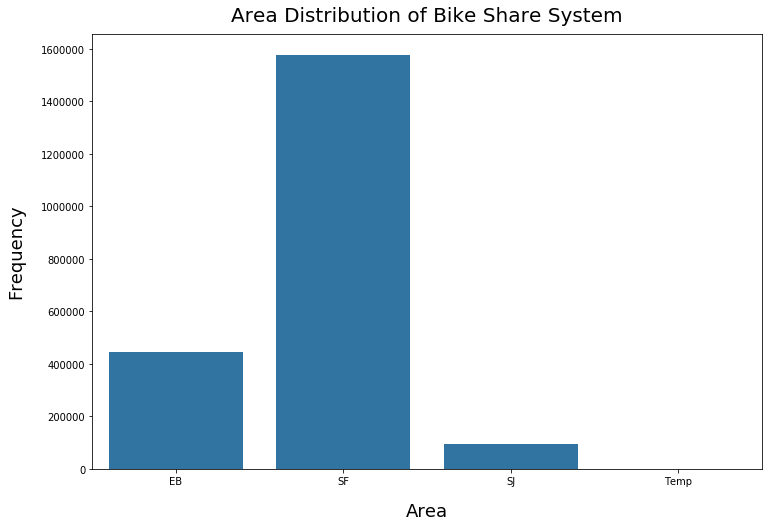

In [180]:
plt.figure(figsize=(12,8))
sb.barplot(data=area_df, x='area', y='count', color = base_color)
plt.title('Area Distribution of Bike Share System', fontsize=20, y=1.015)
plt.xlabel('Area', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)
plt.savefig('Area Distribution of Bike Share System.png')

### The Hourly Trend of Bike Rides per Area
We found out that the operational hours for the temporary stations only from 10am until 11pm and also all of the areas except the temporary stations have the same trend as previous hours graphs where 8am and 5pm is the most crowded; however, the effect for each areas have slight differences: 
1. San Fransisco with the most fluctuative one with 8am and 5pm as its center 
2. East Bay almost the same trend with San Fransisco except of 6pm also crowded 
3. San Jose have the least fluctuation and almost have the same line throughout the graph; however, we can see that there is some similarities with its previous two station trends 

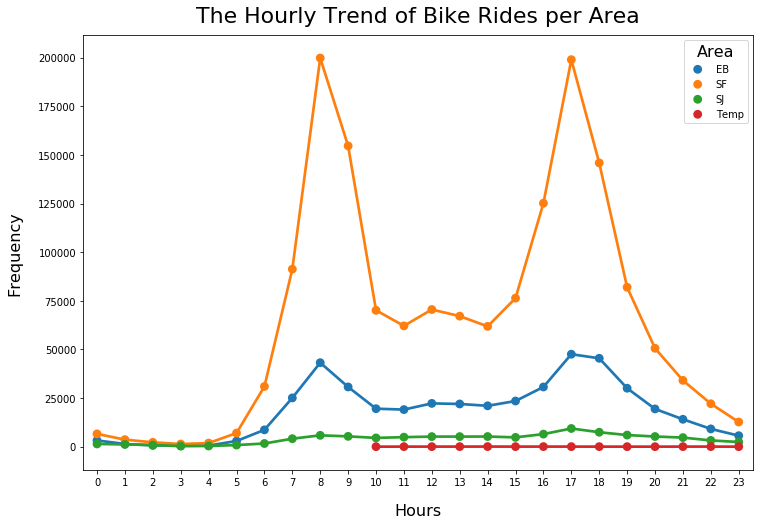

In [194]:
plt.figure(figsize=(12,8))
ax = sb.pointplot(x='start_time_hour', y=0, hue='area', data=area_count_df)
plt.title('The Hourly Trend of Bike Rides per Area', fontsize=22, y=1.015)
plt.xlabel('Hours', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
plt.savefig('The Hourly Trend of Bike Rides per Area')

### The Monthly Trend of Bike Rides per Area
The trend for the temporary station is only operational at August 2018 and San Fransisco station is the only one available at June 2017. The trend is the same as previous graph of monthly trend where all areas (except temporary) have the trend of rising with certain downtrend point for November and December. 

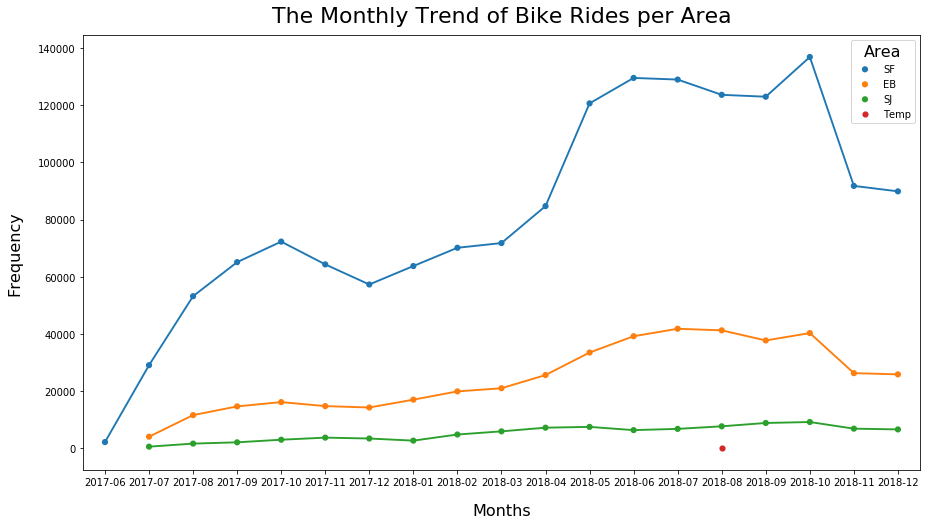

In [184]:
plt.figure(figsize=(15,8))
ax = sb.pointplot(x='start_time_year_month', y=0, hue='area', data=area_count_df2)
plt.title('The Monthly Trend of Bike Rides per Area', fontsize=22, y=1.015)
plt.xlabel('Months', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
plt.savefig('The Monthly Trend of Bike Rides per Area')

### The Daily Trend of Bike Rides per Area
Once again we find out that temporary station only operational at Friday-Sunday. All of the remaining areas follow the same trend: the weekdays have more usage than weekends

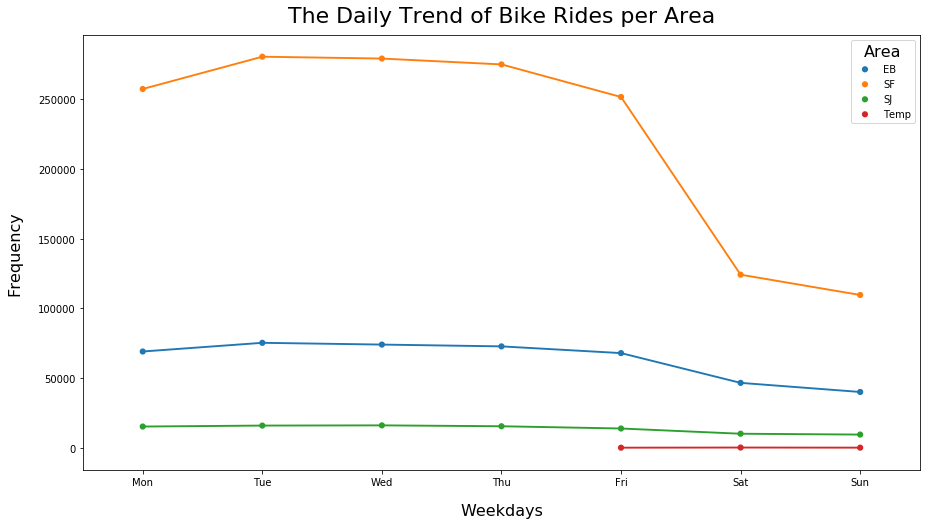

In [186]:
plt.figure(figsize=(15,8))
dayorder = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax = sb.pointplot(x='start_time_weekday_abbr', y=0, hue='area', data=area_count_df3, order=dayorder)
plt.title('The Daily Trend of Bike Rides per Area', fontsize=22)
plt.xlabel('Weekdays', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
plt.savefig('The Daily Trend of Bike Rides per Area')

### Trip Duration Distribution by Area
The average duration of the trips for each area are almost the same except the temporary station where the number of available stations are limited 

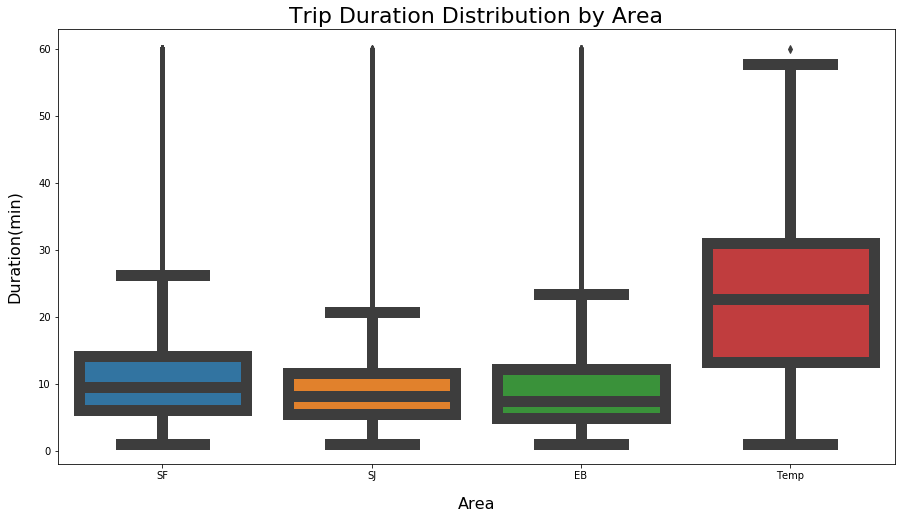

In [197]:
plt.figure(figsize=(15,8))
ax = sb.boxplot(x='area', y='duration_min', linewidth=11, data= df5)
plt.title('Trip Duration Distribution by Area', fontsize=22)
plt.xlabel('Area', fontsize=16, labelpad=16)
plt.ylabel('Duration(min)', fontsize=16, labelpad=16)
plt.savefig('Trip Duration Distribution by Area')

### Question 4: What are the differences between subscriber and normal customer from their trends?

We will uncover deeper with user type variables added to the trends of daily, hourly, monthly and durations

### User Type of the Bike Share System
The subscriber have almost 6x the amount of the non-subscriber customer which makes sense because the benefit for the frequent usage is higher for subscriber who paid for fixed amount rather than the non-subscriber customer who have to pay every time they use the bike 

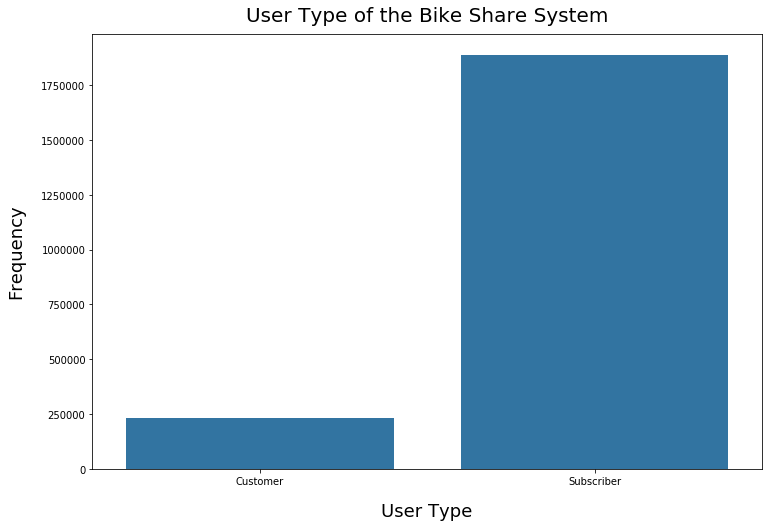

In [198]:
plt.figure(figsize=(12,8))
sb.barplot(data=user_df, x='user_type', y='count', color = base_color)
plt.title("User Type of the Bike Share System", fontsize=20, y=1.015)
plt.xlabel('User Type', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)
plt.savefig('User Type of the Bike Share System')

### The Monthly Trend of Bike Rides per User Type
The monthly trend for each user type is actually similar: the rising trend for the months until the down trends in November and December. 

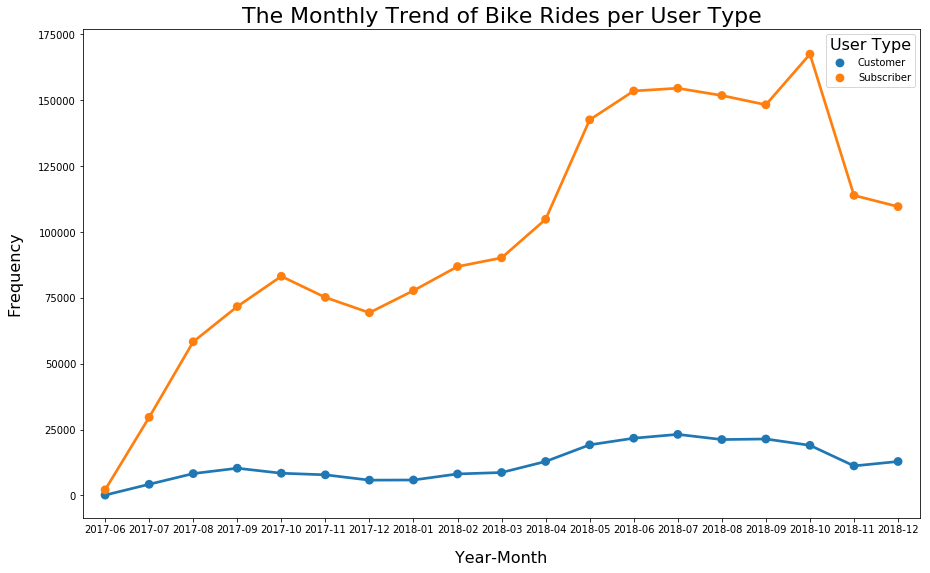

In [190]:
plt.figure(figsize=(15,9))
ax = sb.pointplot(x='start_time_year_month', y=0, hue='user_type', data=user_type_count_df)
plt.title('The Monthly Trend of Bike Rides per User Type', fontsize=22)
plt.xlabel('Year-Month', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
plt.savefig('The Monthly Trend of Bike Rides per User Type')

### The Daily Trend of Bike Rides per User Type 
There is additional information for the non-subscriber customers: they used the bike more during weekends especially Saturday while subscriber used it heavily on weekdays or working days. 

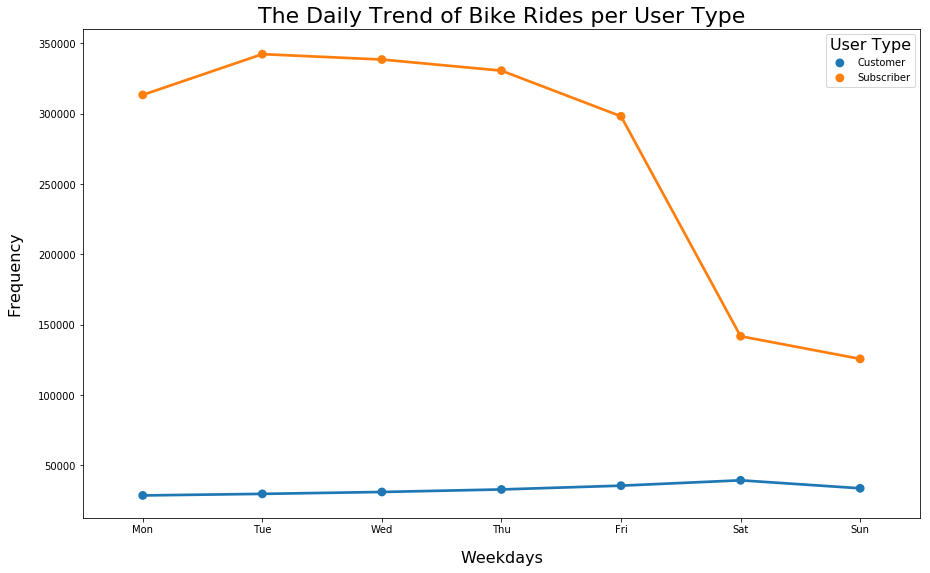

In [191]:
plt.figure(figsize=(15,9))
dayorder = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax = sb.pointplot(x='start_time_weekday_abbr', y=0, hue='user_type', data=user_type_count_df2, order= dayorder)
plt.title('The Daily Trend of Bike Rides per User Type', fontsize=22)
plt.xlabel('Weekdays', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
plt.savefig('The Daily Trend of Bike Rides per User Type')

### The Hourly Trend of Bike Rides per User Type
There is differences for customer and subscriber which is the customer type usage appear to be more disperse compared to subscriber type usage which is more centered toward 8am and 5pm  

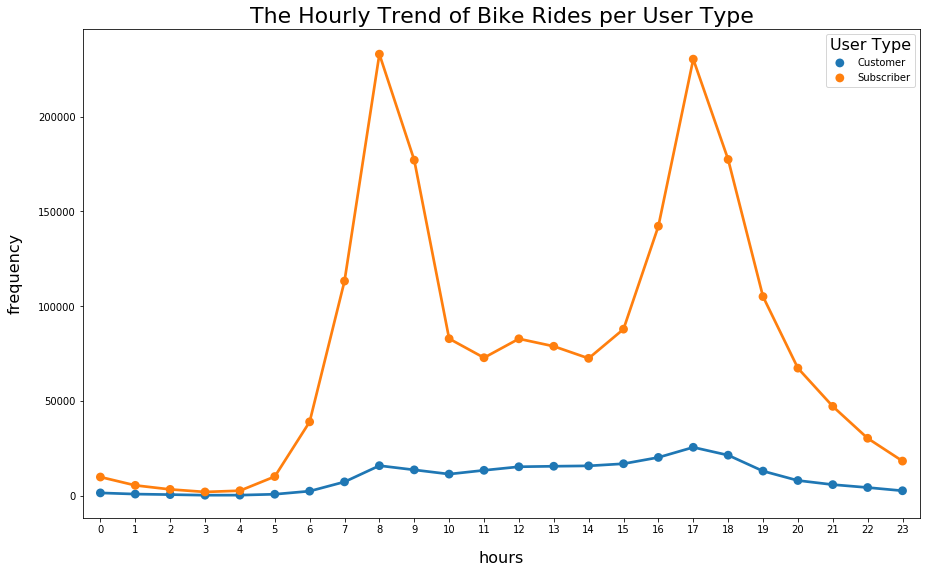

In [195]:
plt.figure(figsize=(15,9))
ax = sb.pointplot(x='start_time_hour', y=0, hue='user_type', data=user_type_count_df3)
plt.title('The Hourly Trend of Bike Rides per User Type', fontsize=22)
plt.xlabel('Hours', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
plt.savefig('The Hourly Trend of Bike Rides per User Type')

### Trip Duration of User Type
The duration trip for the customer is averagely longer than subscriber. Customer also have higher maximum value which indicate that customer duration trip is more disperse compared to subscriber duration trip.

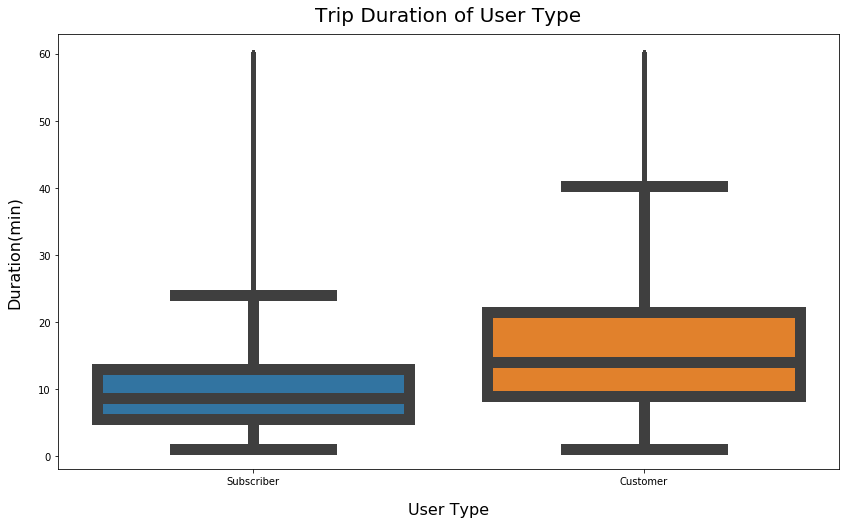

In [196]:
plt.figure(figsize=(14,8))
ax = sb.boxplot(x='user_type', y='duration_min', linewidth=11, data= df5)
plt.title('Trip Duration of User Type', fontsize=20, y=1.015)
plt.xlabel('User Type', fontsize=16, labelpad=16)
plt.ylabel('Duration(min)', fontsize=16, labelpad=16)
plt.savefig('Trip Duration of User Type')

## Conclusion 

After filtering the data of the Ford Go Bike ride from 2017-2018 and answering the questions, we find out that the primary usage of the Ford Go Bike is the go-to-work transportation which is proven by the weekdays usage is higher than weekend usage individually and the most crowded hours are 8am and 5pm (going to work and going home time). The usage downtrend of December 2017 and 2018 also might be caused by the holiday season which reduced the number of worker going to work. From the number of subscriber, we can also indicate that many who rides the bike daily are workers. This can be proven by the fact which the subscriber ride is heavily leaned toward working days rather than weekends as well as the fact that subscriber busy hours are 8am and 5pm which fit the profile for worker profile. 

For people who wanted to know the crowdest moment so they can rent a bike successfully, they can avoid the weekdays 8am and 5pm as well as renting it during holidays month like December. For the operational areas, San Fransisco is the one with the most ride while both East Bay and San Jose are less crowded (though might still be better to avoid 8am and 5pm weekdays in both areas as well as 6pm in East Bay weekdays) 